In [1]:
import random
import math
from operator import itemgetter
import operator

In [2]:
def SplitData(data,M,k,seed):
    test=[]
    train=[]
    random.seed(seed)
    for user,item in data:
        if random.randint(0,M)==k:
            test.append([user,item])
        else:
            train.append([user,item])
    return train,test

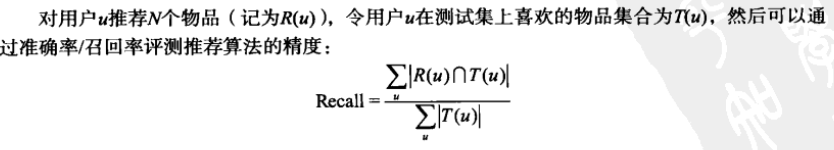

In [3]:
def Recall(train,test,N):
    hit=0
    alll=0
    for user in train.keys():
        tu=test[user]
        # rank得到user的推荐列表
        rank=GetRecommendation(user,N)
        for item,pui in rank.items():
            if item in tu:
                hit +=1
        alll+=len(tu)
    return hit/(alll*1.0)

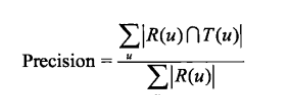

In [4]:
def Precision(train,test,N):
    hit=0
    alll=0
    for user in train.keys():
        tu=test[user]
        rank=GetRecommendation(user,N)
        for item,pui in rank.items():
            if item in tu:
                hit+=1
        alll+=N
    return hit/(alll*1.0)

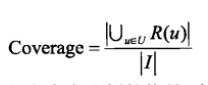

In [5]:
def Coverage(train,test,N):
    recommend_items=set()
    all_items=set()
    for u in train.keys():
        for item in train[key].keys():
            all_items.add(item)
        rank=GetRecommendation(user,N)
        for item,pui in rank:
            recommend_items.add(item)
    return len(recommend_items)/(len(all_items)*1.0)

In [6]:
def Popularity(train,test,N):
    item_popularity=dict()
    # 统计每一个items被看过的次数
    for user,items in train.items():
        if item not in item_popularity:
            item_popularity[item]=0
        item_popularity[item]+=1
    ret=0
    n=0
    for user in train.keys():
        rank=GetRecommendation(user,N)
        for item,pui in rank.items():
            ret+=math.log(1+item_popularity[item])
            n+=1
    ret/=n*1.0
    return ret

- 余弦相似度
###### N(u)表示用户u曾经有过正反馈的物品集合（注意各个N不同）
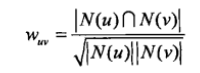

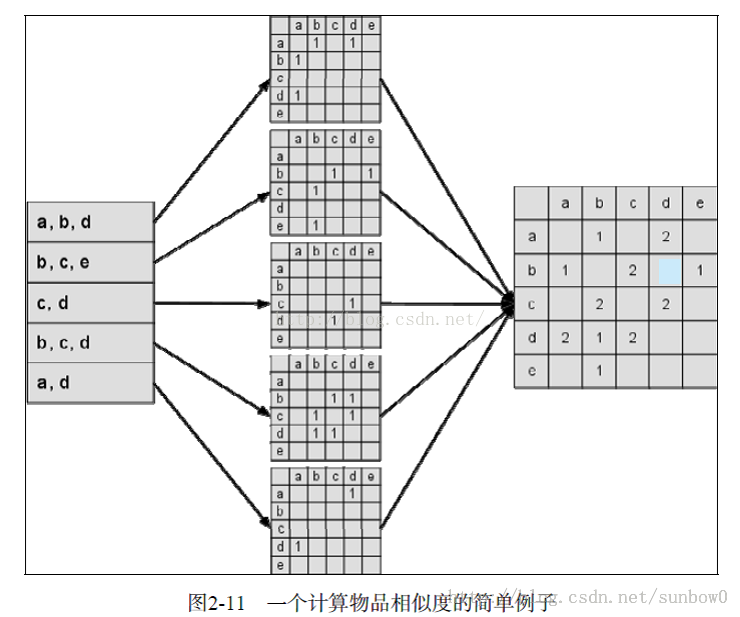
1. 很好的一张图，很快理解，五个小表格代表五个user
2. 换成UserCF，五个小表格代表五个item，横列坐标换成user1~user5


In [7]:
# W为计算余弦相似度
def UserSimilarity(train):
    item_users=dict()
    C=dict()
    N=dict()
    for u,items in train.items():
        if u not in N:
            N[u]=0
        N[u]=len(items)
        for i in items.keys():
            if i not in item_users:
                item_users.setdefault(i,set())
            item_users[i].add(u)
    
    for i,users in item_users.items():
        for u in users:
            for v in users:
                if u==v:
                    continue
                if u not in C:
                    C.setdefault(u,{})
                if v not in C[u]:
                    C[u].setdefault(v,0)
                C[u][v]+=1
    W=dict()
    for u,related_users in C.items():
        for v,C_uv in related_users.items():
            if u not in W:
                W.setdefault(u,{})
            if v not in W[u]:
                W[u].setdefault(v,0)
            W[u][v]=C_uv/math.sqrt(N[u]*N[v])
    return W


In [21]:
# 简单的训练集
train={
    'user1':{
        'item1':1,
        'item2':2,
        'item3':3
    },
    'user2':{
        'item1':3,
        'item3':3,
        'item4':4
    },
    'user3':{
        'item2':4,
        'item4':2,
        'item5':1,
    },
    'user4':{
        'item1':4,
        'item2':5,
    },
    'user5':{
        'item3':4,
        'item5':2,
    }
}

In [22]:
W=UserSimilarity(train)

In [23]:
W

{'user4': {'user1': 0.5889777841036123,
  'user2': 0.2944888920518062,
  'user3': 0.2944888920518062},
 'user1': {'user4': 0.5889777841036123,
  'user2': 0.4808983469629878,
  'user3': 0.2404491734814939,
  'user5': 0.2944888920518062},
 'user2': {'user4': 0.2944888920518062,
  'user1': 0.4808983469629878,
  'user5': 0.2944888920518062,
  'user3': 0.3034130755422791},
 'user3': {'user4': 0.2944888920518062,
  'user1': 0.2404491734814939,
  'user2': 0.3034130755422791,
  'user5': 0.37160360818355515},
 'user5': {'user1': 0.2944888920518062,
  'user2': 0.2944888920518062,
  'user3': 0.37160360818355515}}

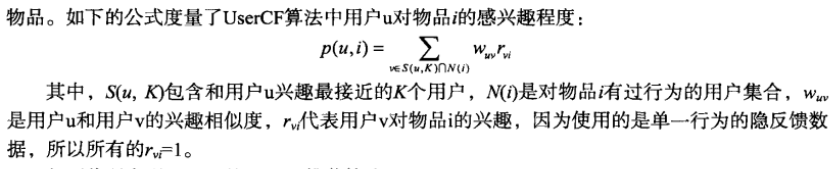

In [24]:
# W为用户余弦相似度
def Recommend(user_id,train,W,K=3):
    rank=dict()
    interacted_items=train[user_id]
    # 在与用户u最相近的K个用户里遍历
    for v,W_uv in sorted(W[user_id].items(),key=operator.itemgetter(1),reverse=True)[0:K]:
        # 在用户v中遍历，找到u没看过的item
        for i,r_vi in train[v].items():
            if i in interacted_items:
                continue
            if i not in rank:
                rank.setdefault(i,0)
            rank[i]+=W_uv*r_vi
    return rank

In [25]:
user='user1'
rank=Recommend(user,train,W,3)
rank

{'item4': 1.923593387851951, 'item5': 0.5889777841036123}

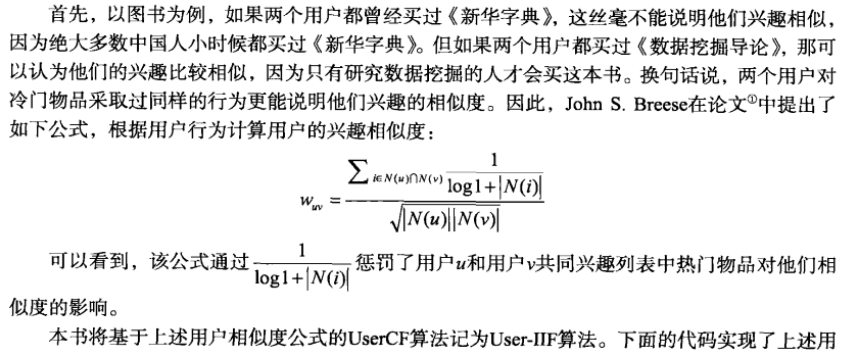

In [26]:
# User_IIF算法
def UserSimilarity2(train):
    item_users=dict()
    for u,items in train.items():
        for i in items.keys():
            if i not in item_users:
                item_users.setdefault(i,set())
            item_users[i].add(u)
    C=dict()
    N=dict()
    for i,users in item_users.items():
        for u in users:
            if u not in N:
                N.setdefault(u,0)
            N[u]+=1
            for v in users:
                if u==v:
                    continue
                if u not in C:
                    C.setdefault(u,{})
                if v not in C[u]:
                    C[u].setdefault(v,0)
                C[u][v]+=1/math.log(1+len(users))
    W=dict()
    for u,related_users in C.items():
        for v,C_uv in related_users.items():
            if u not in W:
                W.setdefault(u,{})
            if v not in W[u]:
                W[u].setdefault(v,0)
            W[u][v]=C_uv/math.sqrt(N[u]*N[v])
    return W


In [27]:
W2=UserSimilarity2(train)
W2

{'user4': {'user1': 0.5889777841036123,
  'user2': 0.2944888920518062,
  'user3': 0.2944888920518062},
 'user1': {'user4': 0.5889777841036123,
  'user2': 0.4808983469629878,
  'user3': 0.2404491734814939,
  'user5': 0.2944888920518062},
 'user2': {'user4': 0.2944888920518062,
  'user1': 0.4808983469629878,
  'user5': 0.2944888920518062,
  'user3': 0.3034130755422791},
 'user3': {'user4': 0.2944888920518062,
  'user1': 0.2404491734814939,
  'user2': 0.3034130755422791,
  'user5': 0.37160360818355515},
 'user5': {'user1': 0.2944888920518062,
  'user2': 0.2944888920518062,
  'user3': 0.37160360818355515}}

In [28]:
user='user1'
rank2=Recommend(user,train,W2,3)
rank2

{'item4': 1.923593387851951, 'item5': 0.5889777841036123}